In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from itertools import islice
import plotly.graph_objects as go

np.random.seed(0)
torch.manual_seed(0)

### Test with 1D identity network : Edge case, not relevant imo

In [2]:
class IdentityNN(torch.nn.Module):
    def __init__(self):
        super(IdentityNN, self).__init__()
        self.fc1 = torch.nn.Linear(1, 2)
        self.fc2 = torch.nn.Linear(2, 1)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            self.fc1.weight[:] = torch.tensor([[1.0], [-1.0]])
            torch.nn.init.constant_(self.fc1.bias, 0)
            torch.nn.init.constant_(self.fc2.bias, 0)
            self.fc2.weight[:] = torch.tensor([[1.0, -1.0]])

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        output = self.fc2(x)
        return output
    
model = IdentityNN()

In [3]:
def compute_crossing_times(model, t_values):
    """
    Compute the times where activations of neurons change.
    """
    crossings = []
    x = torch.tensor(t_values).float().view(-1, 1)      # Parametrize the line  
    tol = 1e-5

    for l,layer in enumerate(model.children()):         # Iterate over layers
        x = layer(x)
        activation = x > 0
        for i in range(activation.shape[1]):            # Iterate over neurons of current layer
            transition_indices = np.where(np.abs(np.diff(activation[:, i])) > 1/2)[0]
            for idx in transition_indices:              # Info useful for debugging
                crossings.append((l, i, t_values[idx]))
        x = torch.relu(x)
    crossing_times = [t for _,_,t in crossings]
    crossing_times = np.unique(crossing_times, axis=0)
    return crossing_times

def compute_gradients(model, crossing_times):           # Finite difference approximation
    """
    Compute the gradients of the model between each crossing times.
    """
    dt = 1e-2
    grad = []

    eval_times = crossing_times - 2 * dt
    eval_times = np.insert(eval_times,-1 , crossing_times[-1] + 2 * dt)
    for t in eval_times:
        x = torch.tensor([t, t + dt]).float().view(-1, 1)
        with torch.no_grad():
            y = model(x)
        dy = np.diff(y.numpy().reshape(-1))
        grad.append(dy/dt)
    
    grad = np.array(grad)
    return grad

t_values = np.linspace(-10, 10, 1000)
crossing_times = compute_crossing_times(model, t_values)
print("Number of regions before gradient check: ", len(crossing_times)+1)

grad = compute_gradients(model, crossing_times)
print("Gradients: \n", grad)
# Gradient check
for i in range(1, len(crossing_times)+1):
    if np.abs(grad[i-1] - grad[i]) < 1e-8:
        crossing_times = np.delete(crossing_times, i-1)

print("Number of regions after gradient check: ", len(crossing_times)+1)
print("Final crossing times: ", crossing_times)

Number of regions before gradient check:  2
Gradients: 
 [[1.]
 [1.]]
Number of regions after gradient check:  1
Final crossing times:  []


### Test with general 1D input network

In [4]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(1, 2)
        self.fc2 = torch.nn.Linear(2, 2)
        self.fc3 = torch.nn.Linear(2, 1)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.uniform_(self.fc1.weight)
        torch.nn.init.uniform_(self.fc1.bias)
        torch.nn.init.uniform_(self.fc2.weight)
        torch.nn.init.uniform_(self.fc2.bias)
        torch.nn.init.uniform_(self.fc3.weight)
        torch.nn.init.uniform_(self.fc3.bias)

    def init_weights_const(self):
        torch.nn.init.constant_(self.fc1.weight, 1)
        torch.nn.init.constant_(self.fc1.bias, 1)
        torch.nn.init.constant_(self.fc2.weight, 2)
        torch.nn.init.constant_(self.fc2.bias, 2)
        torch.nn.init.constant_(self.fc3.weight, 3)
        torch.nn.init.constant_(self.fc3.bias, 3)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        output = self.fc3(x)
        return output

model = FeedForwardNN()

In [5]:
# Let it count

t_values = np.linspace(-10, 10, 10000)
x = torch.tensor(t_values).float().view(-1, 1)      # Parametrize the line
crossing_times = compute_crossing_times(model, t_values)
grad = compute_gradients(model, crossing_times)

for i in range(1, len(crossing_times)+1):
    if np.abs(grad[i-1] - grad[i]) < 1e-5:
        crossing_times = np.delete(crossing_times, i-1)

print("Number of regions after gradient check: ", len(crossing_times)+1)
print("Final crossing times: ", crossing_times)
print("Gradients: \n", grad)

Number of regions after gradient check:  3
Final crossing times:  [-0.95709571 -0.58305831]
Gradients: 
 [[0.        ]
 [0.87768435]
 [0.1852274 ]]


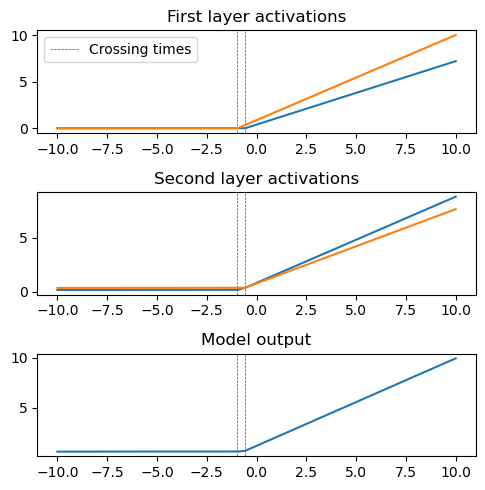

In [6]:
# Some visualization
fig, axs = plt.subplots(3, 1, figsize=(5, 5))

# Plot the function defined by the model
with torch.no_grad():
    y = model(x)
axs[2].plot(x.numpy(), y.numpy(), label='Model output')

# Add vertical lines at the crossing points
for t in crossing_times:
    axs[0].axvline(t, color='r', linestyle='--', linewidth=0.5)
    axs[1].axvline(t, color='r', linestyle='--', linewidth=0.5)
    axs[2].axvline(t, color='r', linestyle='--', linewidth=0.5)

# Also plot the intermediate layer function on a separate plot
with torch.no_grad():
    y = torch.relu(model.fc1(x))
axs[0].plot(x.numpy(), y.numpy())

with torch.no_grad():
    y = torch.relu(model.fc2(y))
axs[1].plot(x.numpy(), y.numpy())

axs[0].set_title('First layer activations')
axs[1].set_title('Second layer activations')
axs[2].set_title('Model output')
axs[0].legend(['Crossing times'])
plt.tight_layout()
plt.show()

### Test general 2D input network

In [7]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(2, 2)
        self.fc2 = torch.nn.Linear(2, 1)
        self.init_weights_random()

    def init_weights(self):
        torch.nn.init.ones_(self.fc1.weight)
        torch.nn.init.ones_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)

    def init_weights_random(self):
        torch.nn.init.normal_(self.fc1.weight)
        torch.nn.init.normal_(self.fc2.weight)
        torch.nn.init.normal_(self.fc1.bias)
        torch.nn.init.normal_(self.fc2.bias)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        output = self.fc2(x)
        return output
    
model = FeedForwardNN()

In [8]:
def compute_crossing_times(model, t_values, direction):
    """
    Compute the times where activations of neurons change.
    """
    crossings = []
    x = direction * t_values.reshape((1, -1))           # Parametrize the line
    x = torch.tensor(x).float().transpose(0, 1)

    for l,layer in enumerate(model.children()):         # Iterate over layers
        with torch.no_grad():
            x = layer(x)
        activation = x > 0
        for i in range(activation.shape[1]):            # Iterate over neurons of current layer
            transition_indices = np.where(np.abs(np.diff(activation[:, i])) > 1/2)[0]
            for idx in transition_indices:              # Info useful for debugging
                crossings.append((l, i, t_values[idx]))
        x = torch.relu(x)
    crossing_times = [t for _,_,t in crossings]
    crossing_times = np.unique(crossing_times, axis=0)
    return crossing_times

def compute_gradients(model, crossing_times):           # Finite difference approximation
    """
    Compute the gradients of the model between each crossing times.
    """
    dt = 1e-4
    grad = []

    eval_times = crossing_times - 2 * dt
    eval_times = np.insert(eval_times,-1 , crossing_times[-1] + 2 * dt)
    for t in eval_times:
        t_values = np.array([t, t + dt])
        x = direction * t_values.reshape((1, -1))
        x = torch.tensor(x).float().view(-1,2)
        with torch.no_grad():
            y = model(x)
        dy = np.diff(y.numpy().reshape(-1))
        grad.append(dy/dt) 
    
    grad = np.array(grad)
    return grad

direction = np.array([1,-1]).reshape((2,1))
t_values = np.linspace(-20, 20, 1000)
crossing_times = compute_crossing_times(model, t_values, direction)
grad = compute_gradients(model, crossing_times)

for i in range(1, len(crossing_times)+1):
    if np.abs(grad[i-1] - grad[i]) < 1e-5:
        crossing_times = np.delete(crossing_times, i-1)

print("Number of regions after gradient check: ", len(crossing_times)+1)
print("Final crossing times: ", crossing_times)
print("Gradients: \n", grad)

Number of regions after gradient check:  5
Final crossing times:  [-3.42342342 -2.54254254  3.14314314  4.06406406]
Gradients: 
 [[ 25075.775]
 [ 14586.261]
 [-21734.615]
 [-32705.69 ]
 [-32700.926]]


In [ ]:
# Plot the 3d function defined by the model

# To visualize in browser:
# pyton -m http.server 8000
# http://localhost:8000/code/interactive_plot.html

line = direction * t_values.reshape((1, -1))

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
x, y = np.meshgrid(x, y)
z = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
z = torch.tensor(z).float()
with torch.no_grad():
    z = model(z)
z = z.numpy().reshape(100, 100)
data = []
for t in crossing_times:
    data.append(go.Scatter3d(
        x=direction[0]*t,
        y=direction[1]*t,
        z=np.array(0),
        mode='markers',
        marker=dict(
            size=5,
            color='green',
        )
    ))
data.append(go.Surface(
        z=z,
        x=x,
        y=y,
        colorscale=[[0, 'black'], [1, 'black']],
        showscale=False,
        opacity=0.8,
        contours=dict(
            x=dict(show=False, color="white", width=2),  # Add meshlines along x
            y=dict(show=False, color="white", width=2),  # Add meshlines along y
            z=dict(show=True, color='White', width=2, size=0.5)  # Turn off z contours if not needed
        )
    )
)
data.append(
    go.Scatter3d(
        x=line[0,:],
        y=line[1,:],
        z=0.0*np.ones(1000),
        mode='markers',
        marker=dict(
            size=1,
            color='red',
        )
    )
)
fig = go.Figure(data=data)
    
fig.update_layout(title='Interactive 3D Plot')
fig.show()
#fig.write_html("./Plots/Surface+line.html")